Evolution Strategies
=======

# Theory
**Evolutionary Strategies (ES)** is a metaheuristic optimization technique to approximate the global optimum of a function.

## Definition
**ES** belong to the family of evolutionary algorithms. Evolutionary algorithms are inspired by the biological theory of evolution. To understand the algorithm, lets give a small recap on the evolutionary process
> Evolutionary process is the adaptation process of organisms overtime, to achieve survival. This process is based on the rule "survival of the fittest" and achieved through natural selection. Natural selection believes that individuals with traits beneficial to their survival can live through generations and pass down the good characteristics to the next generation.

<div style="text-align:center"><img src="https://lilianweng.github.io/posts/2019-09-05-evolution-strategies/EA-illustration.png" width="600"/></div>

By analogy, evolutionary strategies algorithm try to model the process of natural selection, in attempt to achieve this inheritance process of good traits in individuals through the generations. Where in biological systems this process is a way of adaptation, in context of search problem it could be used as an anchor to the optima. So to model the process in context of optimization problems so key concepts needs to be imported
- Population
- Offsprings
- Generation
- Mutation

These concepts will control how evolutionary strategies algorithm explore the search space. In a sense the algorithm will have a greedy temptation of go to the nearest optima, due to the mechanics of natural selection process "i.e. always favouring solutions with good traits". However, introduction of mutation parameter will fight back this temptation by providing worst "un-optimal" solutions in the neighborhood, so the algorithm do not stuck in a local optima. So the general behavior of the algorithm will be to pass down good traits to new solutions, while introducing solutions with good/bad mutations to escape local optima.

<div style="text-align:center"><img src="../Resources/Evolution Strategies - Generation.png" width="600"/></div>

### Algorithm


Evolution strategies use problem repersentation of the solution candicates and it search the search space based on that. So the search space is the same as the search space of the problem.
Unlike other evolutionary algorithms, it does not use any form of crossover; instead, modification of candidate solutions is limited to mutation operators. In this way, Evolution Strategies may be thought of as a type of parallel stochastic hill climbing.

## Examples


# Implementation


## Imports

In [1]:
import matplotlib
import numpy as np
import pandas as pd
from typing import Callable
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
matplotlib.rcParams['animation.embed_limit'] = 2**128 

## Parameters

In [2]:
# generation and offsprings sizes respectively
lam = 20
mu = 10

# mutation control parameters
mean = 0
SD = 1.5

## Algorithm
```mermaid
    flowchart TB

        x_0(Start with starting \nsolution x_0) --> Loop
        x_0 --> population(Initial population)
        population --> Loop
        
        subgraph Loop
            direction LR

            offsprings(Selection of population <br> offsprings) --> condition{Is the best offspring cost better <br>than current cost?}
            condition --> |True| move(Move to offspring)
            condition --> |False| stay(Stay where you are)
            
            move --> Mutation
            stay --> Mutation

            subgraph Mutation
                direction TB
            
                children(Produce children <br>from offsprings using <br> normal distribution) --> add(Create new  population set <br>from offsprings children)
            end

            Mutation --> update(Update population)

        end

        Loop --> return(Return current solution)

        
```

In [3]:
def ES(fitness_func: Callable, generate_children: Callable, lam: int, mu: int, x_0: float, mean: float = 0, SD: float = 1.5, generations: int = int(5e2)) -> tuple[float, list, int]:
    '''
    Evolution strategies algorithm to approximated the global optimum of a given continuous cost function

    Args:
        fitness_func: Cost function, for this algorithm it should be 1D continues mathematical expression, function should return float
        generate_children: Generate solution neighbors sampled from normal distribution. function should return np array 
        lam: Size of population
        mu: Size of offsprings
        x_0: Search start value
        mean: Mutation parameter. Defaults to 0.
        SD: Mutation parameter. Defaults to 1.5.
        generations: Maximum number of generations. Defaults to int(5e2).

    Returns:
        The optimal x value of the cost function, the number of accepted samples during search, and the search
        history record.
    '''

    # parameters
    population = generate_children(x_0, size=lam, mean=mean, SD=SD)
    number_children = int(lam/mu)
    accepted_samples = 0

    # algorithm data 
    generations_population = [population]
    mutation_parameters = [[mean, SD]]
    fitness = [fitness_func(x_0)]
    x = [x_0]


    for _ in range(generations-1):
        
        # offsprings selection
        population_fitness = np.array([fitness_func(neighbor) for neighbor in population])
        offsprings = population[ population_fitness.argsort()[:mu] ]


        # check the merit of best offspring 
        best_offspring = offsprings[0]

        ## accept it if better fitness
        if fitness_func(best_offspring) < fitness_func(x[-1]):
            x.append(best_offspring)
            fitness.append(fitness_func(best_offspring))
            generations_population.append(population)
            accepted_samples+=1

        ## reject it "keep current best"
        else:
            x.append(x[-1])
            fitness.append(fitness_func(x[-1]))
            generations_population.append(population)


        # produce new population "with mutation"
        offsprings_children = []
        for offspring in offsprings:
            children = generate_children(offspring, size=number_children, mean=mean, SD=SD)
            offsprings_children.extend(children)
       
        population = np.array(offsprings_children)
        mutation_parameters.append([mean, SD])

    x_optimal, history = x[-1], pd.DataFrame({"fitness": fitness, "x": x, "population": generations_population, "mutation": mutation_parameters})


    return x_optimal, accepted_samples, history

## Results Visualization & Behaver Analysis
In this section we will illustrate the results and behavior of evolution strategies by solving the following problem
- Find global optima in a mathematical function

We will illustrate the results of the algorithm in two means:
- gif Plot: Search process of algorithm to illustrate how populations fitness evolve through generations to reach optimal fitness
- Samples Plot: Search samples taken and show the suggested global optima
- Parameters Tracking Plot: ES parameters tracking, illustrate mutation parameters behavior though generations, tacking of x value and cost to shows how algorithm explore search space

In [4]:
# cost function and neighborhood definition
def cost_func(x: float) -> float:
    '''
    The cost is calculated use a mathematical expression "i.e. the mathematical function to be optimized"
    '''
    return 30*np.sin(x) + x**2

def get_neighborhood(x: float, size: int, mean: float = 0, SD: float = 1.5) -> np.array:
    '''
    The neighborhood around x is defined as the sampled values from a normal distribution centred on x. This means that the bonds 
    of the neighborhood of x is infinite. Note that x is excluded from this list.
    '''
    return x + np.random.normal(loc=mean, scale=SD, size=size)

# starting value search
x_0 = 8

In [5]:
x_optimal, accepted_samples, history = ES(fitness_func=cost_func,
                                          generate_children=get_neighborhood,
                                          lam=20,
                                          mu=10,
                                          x_0=x_0,
                                          generations=20
                                          )

In [6]:
%%capture
fig, ax = plt.subplots(figsize=(6,6))

# fine domain and range limits
xx = np.linspace(min(map(min, history["population"]))-4, max(map(max, history["population"]))+4, num=100)
y_lim = [np.min(cost_func(xx))-0.2*np.ptp(cost_func(xx)), np.max(cost_func(xx))+0.2*np.ptp(cost_func(xx))]

# evolution strategies sampling animation 
## statics components
main_function,      = ax.plot(xx, cost_func(xx), "k")
sample_x_ticks,     = ax.plot([history["x"][0]], [y_lim[0]], "r|", clip_on=False, zorder=100)
sample_line,        = ax.plot([], [], "r--")
sample_point,       = ax.plot([], [], "ro")
population_point,   = ax.plot([], [], "r2", label="Population")
generation_count,   = ax.plot([], [], "k>", label="Generation = "+"{:.2f}".format(1))

## decorations
ax.set(xlabel="x", ylabel="f(x)", ylim=y_lim, title="Evolution Strategies Generations")
legend = ax.legend()

ax.grid(True)

def animate(frame: int) -> tuple:

    ## animated components
    sample_line.set_data([history["x"][frame], history["x"][frame]], [y_lim[0], cost_func(history["x"][frame])])
    sample_point.set_data([history["x"][frame]], [cost_func(history["x"][frame])])
    population_point.set_data([history["population"][frame]], [cost_func(history["population"][frame])])
    sample_x_ticks.set_data([history["x"][:frame]], [y_lim[0]])
    legend.get_texts()[1].set_text("Generation = "+"{}".format(frame+1))

    return sample_line, population_point, sample_point, sample_x_ticks

ani = FuncAnimation(fig, animate, frames=len(history["x"]), blit=True, interval=30)

ani.save('../Resources/Evolution Strategies-Result.gif', writer=PillowWriter(fps=1))

<div style="text-align:center"><img src="../Resources/Evolution Strategies-Result.gif" width="500"/></div>  
<em>If the gif is not updated, please reopen the notebook.</em>

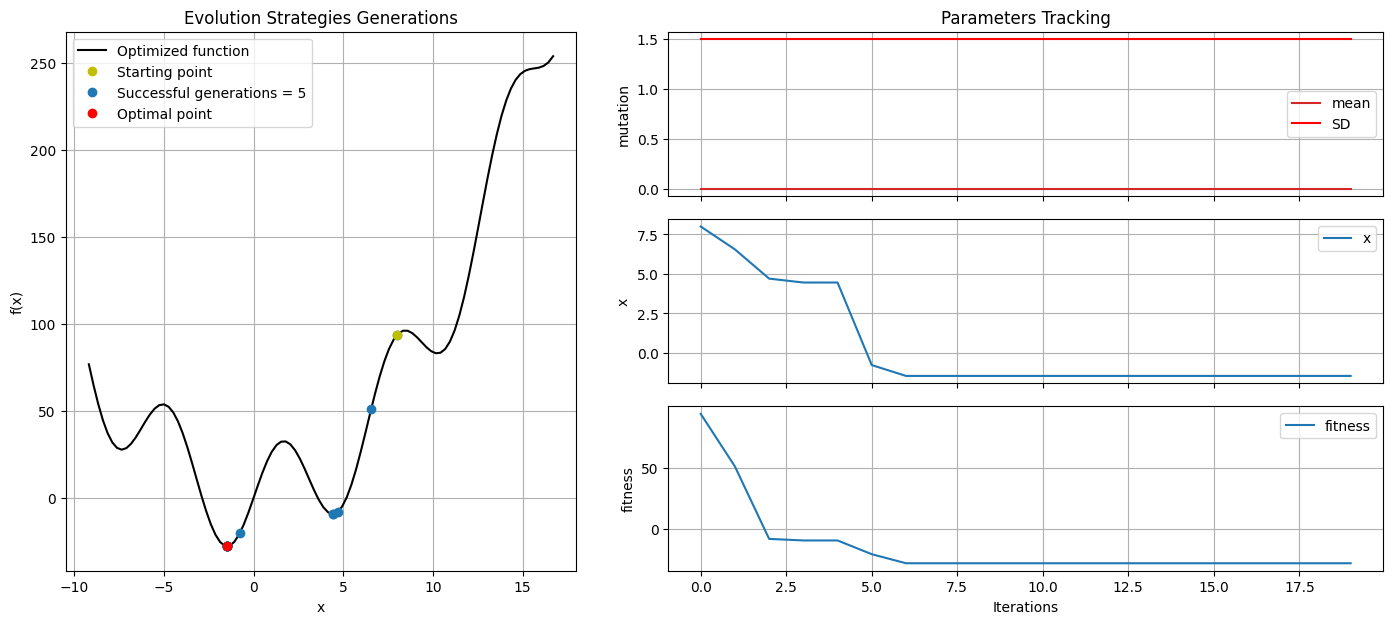

,Property,Value
0,optimal x,-1.457639
1,fitness at optimal x,-27.683425
2,total search generations,20 samples
3,accepted generations,5 samples
4,rejected generations,15 samples


In [7]:
fig, ax = plt.subplot_mosaic([['upper left', 'upper right'],
                              ['upper left',       'right'],
                              ['upper left', 'lower right']],
                             figsize=(17,7), gridspec_kw={'width_ratios': [1, 1.4]})


# evolution strategies sampling plot
ax['upper left'].plot(xx, cost_func(xx), "k", label="Optimized function")
ax['upper left'].plot(history["x"][0], cost_func(history["x"][0]), "yo", label="Starting point", zorder=4)
ax['upper left'].plot(history["x"], cost_func(history["x"]), "o", label=f"Successful generations = {accepted_samples}")
ax['upper left'].plot(x_optimal, cost_func(x_optimal), "ro", label="Optimal point")
ax['upper left'].set(xlabel="x", ylabel="f(x)", title="Evolution Strategies Generations")
ax['upper left'].grid(True)
ax['upper left'].legend()

# mutation parameters tracking
ax['upper right'].plot(history["mutation"].apply(lambda x:x[0]), "tab:red", label="mean")
ax['upper right'].plot(history["mutation"].apply(lambda x:x[1]), "r", label="SD")
ax['upper right'].set(ylabel="mutation", title="Parameters Tracking")
ax['upper right'].xaxis.set_ticklabels([])
ax['upper right'].grid(True)
ax['upper right'].legend()

# x value tracking
ax['right'].plot(history["x"], label="x")
ax['right'].xaxis.set_ticklabels([])
ax['right'].set(ylabel="x")
ax['right'].grid(True)
ax['right'].legend()

# cost value tracking
ax['lower right'].plot(history["fitness"], label="fitness")
ax['lower right'].set(xlabel="Iterations", ylabel="fitness")
ax['lower right'].grid(True)
ax['lower right'].legend()

# summary
summary = [
    ("optimal x", x_optimal),
    ("fitness at optimal x", cost_func(x_optimal)),
    ("total search generations", f'{len(history["x"])} samples'),
    ("accepted generations", f'{accepted_samples} samples'),
    ("rejected generations", f'{len(history["x"]) - accepted_samples} samples')
    ]

df = pd.DataFrame(data=summary, columns=["Property", "Value"])

plt.subplots_adjust(wspace=0.15, hspace=0.14)
plt.show()
df